In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as cfeature
from eofs.xarray import Eof
import cartopy.crs as ccrs

In [2]:
#reading in psl_anomaly data (psl - climatology) data in Pa
#psl_djf_anomaly = xr.open_dataset('/gws/nopw/j04/extant/users/slbennie/psl_anomalies/historical/HadGEM3-GC31-LL/psl_mon_historical_HadGEM3-GC31-LL_r11i1p1f3_DJF_anomaly.nc')
psl_djf_anomaly = xr.open_dataset('/gws/nopw/j04/extant/users/slbennie/psl_anomalies/historical/HadGEM3-GC31-LL/psl_mon_historical_HadGEM3-GC31-LL_r11i1p1f3_DJF_anomaly.nc')
psl_djf_anomaly = psl_djf_anomaly.sel(year=slice(1851,2014))
psl_djf_anomaly = psl_djf_anomaly.sel(lat=slice(20,80), lon=slice(-90,40))
print(psl_djf_anomaly)
#print(psl_djf_anomaly['year'].values)

#The NAO pattern from the ensemble mean, also in Pa/Pa?
#need to shift the coordinates or like stitch for the NA region.
ds = xr.open_dataset('/gws/nopw/j04/extant/users/slbennie/CVDP_outputs/NAO/historical/historical_NAO/HadGEM3-GC31-LL_EM.cvdp_data.nao.1850-2014.nc')
#ds = xr.open_dataset('/gws/nopw/j04/extant/users/slbennie/CVDP_outputs/NAO/historical/historical_NAO/HadGEM3-GC31-LL_r11i1p1f3.cvdp_data.1850-2014.nc')
ds = ds['nao_pattern_djf_em']

#finding the longitudes that are greater than 180
new_lon = np.where(ds.lon > 179, ds.lon -360, ds.lon)

#creating a copy of the data array where the longitudes have been shifted
ds_shifted = ds.copy()
ds_shifted.coords['lon'] = new_lon

#Now need to make sure they are in the correct order and then re-index to make sure the lon get put to match the sorted lon
sorted_lon = np.sort(ds_shifted.lon)
ds_shifted = ds_shifted.sel(lon=sorted_lon)

print(ds_shifted)


historical_NAO_pattern = ds_shifted.sel(lat=slice(20,80), lon=slice(-90,40))
#print(historical_NAO_pattern)


<xarray.Dataset> Size: 2MB
Dimensions:   (lat: 25, lon: 53, year: 164, bnds: 2)
Coordinates:
  * lat       (lat) float64 200B 20.0 22.5 25.0 27.5 ... 72.5 75.0 77.5 80.0
  * lon       (lon) float64 424B -90.0 -87.5 -85.0 -82.5 ... 32.5 35.0 37.5 40.0
  * year      (year) int64 1kB 1851 1852 1853 1854 1855 ... 2011 2012 2013 2014
    season    <U3 12B ...
Dimensions without coordinates: bnds
Data variables:
    lat_bnds  (year, lat, bnds) float64 66kB ...
    lon_bnds  (year, lon, bnds) float64 139kB ...
    psl       (year, lat, lon) float64 2MB ...
<xarray.DataArray 'nao_pattern_djf_em' (lat: 71, lon: 144)> Size: 41kB
[10224 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 568B -87.5 -85.0 -82.5 -80.0 ... 80.0 82.5 85.0 87.5
  * lon      (lon) float64 1kB -180.0 -177.5 -175.0 -172.5 ... 172.5 175.0 177.5
Attributes:
    nens:       50
    long_name:  NAO spatial pattern (DJF) Ensemble Mean
    pcvar:      40.6%*
    units:      hPa


In [3]:
# ERA5 november sst anomalies projected onto era5 regression pattern
# Weight SST data by coslat to account for grid cell area decreasing with latitude
weights = np.cos(np.radians(psl_djf_anomaly["lat"].values))
weights_2d_era = weights[:, np.newaxis]

# weight sst anomalies by area of each gridcell
weighted_psl = psl_djf_anomaly["psl"] * weights_2d_era
weighted_regression = np.nan_to_num(historical_NAO_pattern * weights_2d_era)

 
# Combine lat and lon dimensions
weighted_psl_flat = weighted_psl.stack(spatial=["lat", "lon"])

 
# flatten weighted regression pattern
regression_flat = weighted_regression.flatten()

 
# dot product (weighted projection) between the weighted SST anomalies and regression pattern
weighted_projection = (weighted_psl_flat * regression_flat).sum(dim="spatial")


# normalise for unit variance
total_variance = np.sum(regression_flat**2)

NAO_djf_index = weighted_projection / total_variance

NAO_djf_index_norm = NAO_djf_index / np.sqrt(np.sum(np.abs(NAO_djf_index)))

In [4]:
#print(NAO_djf_index['year'])

In [5]:
ds_CVDP = xr.open_dataset('/gws/nopw/j04/extant/users/slbennie/CVDP_outputs/NAO/historical/historical_NAO/HadGEM3-GC31-LL_r11i1p1f3.cvdp_data.1850-2014.nc')
ds_CVDP_djf = ds_CVDP['nao_timeseries_djf'].isel(TIME=slice(1, None))
#ds_CVDP_djf.plot()
#print(len(ds_CVDP_djf))

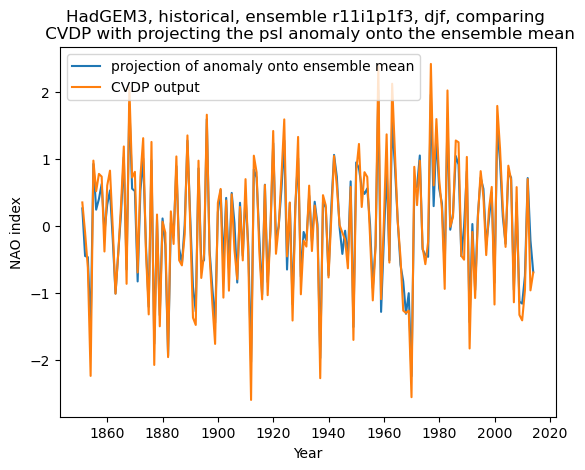

In [6]:
time_NAO = np.arange(1851,2015)
fig, ax = plt.subplots()

ax.plot(time_NAO, NAO_djf_index_norm, label="projection of anomaly onto ensemble mean")
ax.plot(time_NAO, ds_CVDP_djf, label='CVDP output')
ax.set_title('HadGEM3, historical, ensemble r11i1p1f3, djf, comparing \n CVDP with projecting the psl anomaly onto the ensemble mean')
ax.set_ylabel('NAO index')
ax.set_xlabel('Year')
ax.legend()
plt.savefig('historical_anomaly_projection_NAO_index_ens_mean_clim')